In [59]:
import os
import json
import pandas as pd
import numpy as np
import sys

In [60]:
with open(os.path.join("OPs_used", "wavelength.json"), 'r') as f:
    used_wl = json.load(f)
    used_wl = used_wl['wavelength']
with open(os.path.join("OPs_used", "bloodConc.json"), 'r') as f:
    bloodConc = json.load(f)
    bloodConc = bloodConc['bloodConc']
    
# SO2_used = {'SO2': [i/100 for i in range(90,101,1)]}
# SO2_used = {'SO2': [0.9, 0.93, 0.94, 0.945, 0.949, 0.95, 0.951, 0.955, 0.96, 0.97, 1]}
SO2_used = {'SO2': [0.65, 0.68, 0.69, 0.695, 0.699, 0.7, 0.701, 0.705, 0.71, 0.72, 0.75]}
with open(os.path.join("OPs_used", "muscle_SO2.json"), 'w') as f:
    json.dump(SO2_used, f)
SO2_used = SO2_used['SO2']

## Plot the result 
### compare the literature muscle mua spectrum and we build muscle mua spectrum by different substance concentrations.


In [61]:
import matplotlib.pyplot as plt

## Get literature muscle mua spectrum

In [62]:
def get_spec(used_wl, mua_bound, tissue, num):
    spec = {}
    for wl in used_wl:
        spec[f'{wl}nm'] = []
    for wl in used_wl:
        [mua_max, mua_min] = mua_bound[f'{wl}nm'][tissue]
        mua = list(np.linspace(mua_max,mua_min,num))
        for i in range(len(mua)):
            spec[f'{wl}nm'].append(mua[i])
    
    return spec

num = 3 # number of spectrum used
with open(os.path.join("OPs_used","mua_wl_bound.json"),"r") as f:
    mua_bound = json.load(f)
tissue = 'muscle'
muscle_mua_spec_literature = get_spec(used_wl, mua_bound, tissue, num)

## Get the muscle mua spectrum by setting substanece concentration mua and combine it.

In [63]:
path = os.path.join("OPs_used", "absorption", "absorption.xlsx")
file = pd.read_excel(path, sheet_name='muscle_cal')
file = file.iloc[file.index[np.in1d(file['wl'],used_wl)]]

wl = file['wl'].to_numpy()
hbo2 = file['hbo2'].to_numpy()
hb = file['hb'].to_numpy()
water = file['water'].to_numpy()
col = file['col'].to_numpy()
muscle_mua_spec_literature_numpy = pd.DataFrame(muscle_mua_spec_literature).to_numpy()

blood_ratio = 0.003
muscle_mua = {}
muscle_mua_plot = np.empty((len(bloodConc), len(SO2_used), len(used_wl))) 
for b_idx, blc in enumerate(bloodConc):
    muscle_mua_save = np.empty((len(SO2_used), len(used_wl)+1)) # record SO2 + wavelength
    for idx, SO2 in enumerate(SO2_used):
        muscle_mua[f'muscle_mua_bloodConc_{blc}'] = 0.1*2.303*blood_ratio*blc*(hbo2*SO2+hb*(1-SO2))/64500 + 0.3*col
        muscle_mua_plot[b_idx][idx] = muscle_mua[f'muscle_mua_bloodConc_{blc}']
        muscle_mua_save[idx] = np.array([SO2]+list(muscle_mua[f'muscle_mua_bloodConc_{blc}']))
    columns = ['SO2'] + [f'{wl}_nm' for wl in used_wl]
    muscle_mua_save = pd.DataFrame(muscle_mua_save, columns=columns)
    muscle_mua_save.to_csv(os.path.join("OPs_used", f"muscle_mua_bloodConc_{blc}.csv"), index=False)

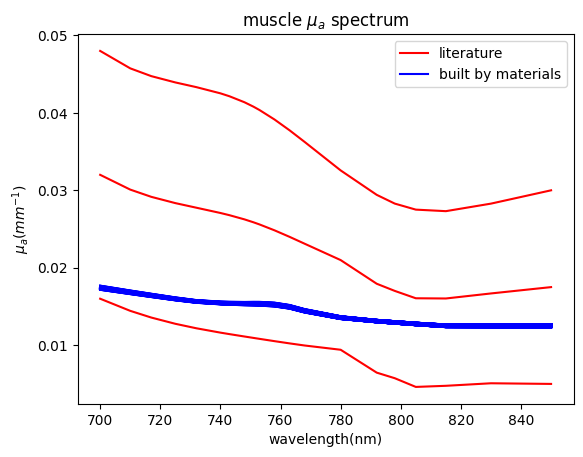

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


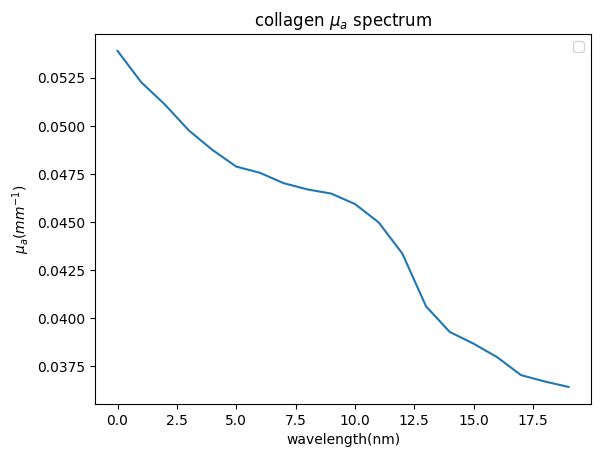

In [64]:
os.makedirs(os.path.join("pic"), exist_ok=True)
spec_numpy = pd.DataFrame(muscle_mua_spec_literature).to_numpy()
for i in range(spec_numpy.shape[0]):
    if i == 0:
        plt.plot(used_wl,spec_numpy[i], 'r', label='literature')
    else:
        plt.plot(used_wl,spec_numpy[i], 'r')
for b_idx in range(len(bloodConc)):
    for s_idx in range(len(SO2_used)):
        if b_idx==0 and s_idx == 0:
            plt.plot(wl, muscle_mua_plot[b_idx][s_idx], 'b', label=f'built by materials')
        else:
            plt.plot(wl, muscle_mua_plot[b_idx][s_idx], 'b')
plt.xlabel('wavelength(nm)')
plt.ylabel("$\mu_a$($mm^{-1}$)")
plt.title(f'muscle $\mu_a$ spectrum')
plt.legend()
plt.savefig(os.path.join("pic", 'muscle_mua_spectrum.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.plot(col)
plt.xlabel('wavelength(nm)')
plt.ylabel("$\mu_a$($mm^{-1}$)")
plt.title(f'collagen $\mu_a$ spectrum')
plt.legend()
plt.savefig(os.path.join("pic", 'collagen_mua_spectrum.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

In [66]:
# Get muscle_with_blood mua
muscle_mua_spec = {}
for blc in bloodConc:
    spec = pd.read_csv(os.path.join("OPs_used", f"muscle_mua_bloodConc_{blc}.csv"))
    spec = spec.to_numpy()
    for s_idx, SO2 in enumerate(SO2_used):
        muscle_mua_spec[f'muscle_bloodConc_{blc}_bloodSO2_{SO2}'] = list(spec[s_idx][1:]) # first element(0-index) represent SO2

with open(os.path.join("OPs_used", f'muscle_mua_spectrum.json'), 'w') as f:
    json.dump(muscle_mua_spec, f)